# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Session 07: Relational Structure + Pivot

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

![](../img/IntroRDataScience_NonTech-1.jpg)

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

![](../img/DK_Logo_100.png)

***

### 0. What do we want to do today?

The Relational Data Model: we will work to build an understanding of **join operations** in **relational structures** (e.g. sets of Pandas dataframes where mutual relations among them are described by sets of key columns). Next we will learn about **pivot/unpivot** operations in Pandas, i.e. reshaping Pandas Dataframes from **Long-to-Wide** and **Wide-to-Long** formats. 

**Prerequisites**

- By now, you are able to
- load the data to `pd.DataFrame`,
- inspect the nature of the data,
- use charts of different kind for representing data graphically,
- make some conclusions based on the previous steps.

### 1. Where am I?

Your are (or you should be...) in the `session07` directory, where we find 
- this notebook, 
- it's HTML version, 
- another directory `_data` that contains CSV files from `nycflights13`: 
   - `airlines.csv`
   - `flights.csv`
   - `weather.csv`
   - `planes.csv`
   - `airports.csv`

In [1]:
import os
work_dir = os.getcwd()
print(work_dir)
print(os.listdir(work_dir))
data_dir = os.path.join(work_dir, "_data")
os.listdir(data_dir)

/Users/goransm/Work/___DataKolektiv/_EDU/DSS_Vol00_PythonDS_2023/dss03python2023/session07
['dss03_py_session07.ipynb', '.DS_Store', '.ipynb_checkpoints', '_data']


['airlines.csv', 'weather.csv', 'airports.csv', 'planes.csv', 'flights.csv']

### Load the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data

Today we are working with [nycflights13 dataset](https://github.com/tidyverse/nycflights13). The data in `nycflights13` were originaly provided in an R package; we have extracted all tables present to CSV files and placed them in our `_data` directory to play with. It consists of data about flights that departed all airports in NYC in 2013 (tables: `airlines`, `airports`, `weather`, `flights` and `planes`).

The data set also includes useful metadata on airlines, airports, weather, planes, and flights departing NYC in 2013.

An excellent overview of these data is given in [R for Data Science, Chapter 13 Relational Data, Hadley Wickham & Garrett Grolemund, 2017](https://r4ds.had.co.nz/relational-data.html).

Let's load and inspect the `flights.csv` data set first.

In [3]:
flights = pd.read_csv(os.path.join(data_dir, 'flights.csv'), index_col=0)
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
1,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00
2,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00
3,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00
4,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00
5,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00


The `tailnum` column in `flights` contains the plain tail number:

In [4]:
flights['tailnum'].head(10)

1     N14228
2     N24211
3     N619AA
4     N804JB
5     N668DN
6     N39463
7     N516JB
8     N829AS
9     N593JB
10    N3ALAA
Name: tailnum, dtype: object

Let's load the `planes` data now.

In [5]:
planes = pd.read_csv(os.path.join(data_dir, 'planes.csv'), index_col=0)
planes.head()

,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
1,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan
2,N102UW,1998.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
3,N103US,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
4,N104UW,1999.0,Fixed wing multi engine,AIRBUS INDUSTRIE,A320-214,2,182,NaN,Turbo-fan
5,N10575,2002.0,Fixed wing multi engine,EMBRAER,EMB-145LR,2,55,NaN,Turbo-fan


The same column, `tailnum`, is present in `planes` too. 

**N.B.** For what follows, it is not necessary that any pair of columns containing data that can be matched also bear the same name in two DataFrames (to be elaborated in the live session).

We are interested to learn what `manufacturer` (in `planes`) produced the planes that flew the most of the flights present in `flights`. The frequency data - how many flights were observed by plane - are known from the `flights` DataFrame, where planes are identified by their `tailnum`. However, the data on `manufacturer` are found only in the `planes` DataFrame, where planes are also identified by their `tailnum`. We need to bring these two DataFrames, or subsets of them, together in order to merge the information from `flights` with the data in `planes` and proceed with our analysis of `manufacturers`.

These are the steps that we will follow in order to perform our analysis:
- group `flights` by `tailnum` and count the number of flights per plane;
- **join** the resulting DataFrame to `planes`;
- inspect what manufacturers produced the most frequently flied aricrafts.

### Left and right join in Pandas

Step 1: Group `flights` by `tailnum` and count the number of flights per plane.

In [6]:
tailnum_counts = flights['tailnum']\
    .value_counts()\
    .reset_index()\
    .rename(columns={'index':'tailnum', 'tailnum':'count'})\
    .sort_values(by='count', ascending=False)
tailnum_counts

,tailnum,count
0,N725MQ,575
1,N722MQ,513
2,N723MQ,507
3,N711MQ,486
4,N713MQ,483
...,...,...
3928,N843MH,1
3929,N844MH,1
3930,N705SK,1
3931,N595NW,1


Step 2. **Join** the resulting DataFrame to `manufacturers` from `planes`.

In [7]:
manufacturers = planes[['tailnum', 'manufacturer']]
manufacturers.head(10)

,tailnum,manufacturer
1,N10156,EMBRAER
2,N102UW,AIRBUS INDUSTRIE
3,N103US,AIRBUS INDUSTRIE
4,N104UW,AIRBUS INDUSTRIE
5,N10575,EMBRAER
6,N105UW,AIRBUS INDUSTRIE
7,N107US,AIRBUS INDUSTRIE
8,N108UW,AIRBUS INDUSTRIE
9,N109UW,AIRBUS INDUSTRIE
10,N110UW,AIRBUS INDUSTRIE


We will use `.merge()` to perform a join, specifying `how='left'` to perform a **left join**, and using `on='tailnum'` to specify the key:

In [8]:
manufacturers = manufacturers.merge(tailnum_counts, how='left', on='tailnum')
manufacturers

,tailnum,manufacturer,count
0,N10156,EMBRAER,153
1,N102UW,AIRBUS INDUSTRIE,48
2,N103US,AIRBUS INDUSTRIE,46
3,N104UW,AIRBUS INDUSTRIE,47
4,N10575,EMBRAER,289
...,...,...,...
3317,N997AT,BOEING,44
3318,N997DL,MCDONNELL DOUGLAS AIRCRAFT CO,63
3319,N998AT,BOEING,26
3320,N998DL,MCDONNELL DOUGLAS CORPORATION,77


And now:

In [9]:
manufacturers_count = manufacturers[['manufacturer', 'count']]\
    .groupby('manufacturer')\
    .agg(sum)\
    .reset_index()\
    .rename(columns={'count':'sum'})\
    .sort_values(by='sum', ascending=False)
manufacturers_count

,manufacturer,sum
9,BOEING,82912
17,EMBRAER,66068
1,AIRBUS,47302
2,AIRBUS INDUSTRIE,40891
10,BOMBARDIER INC,28272
28,MCDONNELL DOUGLAS AIRCRAFT CO,8932
27,MCDONNELL DOUGLAS,3998
11,CANADAIR,1594
29,MCDONNELL DOUGLAS CORPORATION,1259
13,CESSNA,658


... and that would be `BOEING`, right?

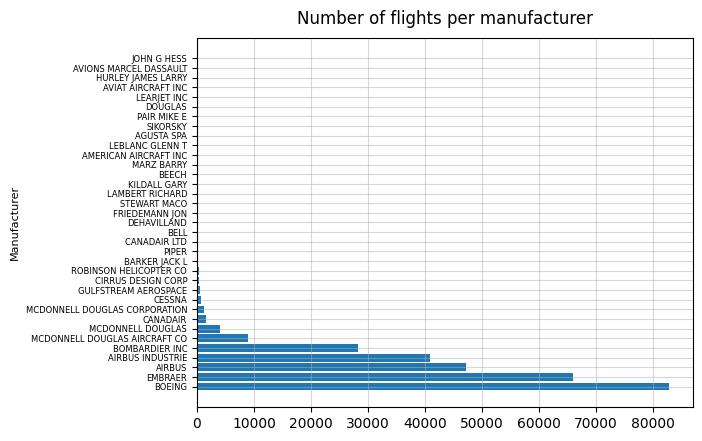

In [10]:
fig, ax = plt.subplots()
ax.barh(y='manufacturer', width='sum', data=manufacturers_count)
ax.set_title('Number of flights per manufacturer', size=12, pad=10)
ax.set_ylabel(ylabel='Manufacturer', fontsize=8)
ax.tick_params(axis='y', which='major', labelsize=6)
ax.grid(alpha=.5)

When a left join is performed, the data in the left table stays completely unchanged (except for the inclusion of new columns). Let's see: who works where?

In [11]:
df_left = pd.DataFrame({'Name':['Peter', 'Anna', 'John', 'Marina', 'Suzana'],
                        'Department':['English', 'English', 'Russian', 'German', 'Spanish']})
df_left

,Name,Department
0,Peter,English
1,Anna,English
2,John,Russian
3,Marina,German
4,Suzana,Spanish


In [12]:
df_right = pd.DataFrame({'Department':['English', 'Russian', 'German'],
                         'Building':['IA', 'II', 'II']})
df_right

,Department,Building
0,English,IA
1,Russian,II
2,German,II


In [13]:
df_result = df_left.merge(df_right, how='left', on='Department')
df_result

,Name,Department,Building
0,Peter,English,IA
1,Anna,English,IA
2,John,Russian,II
3,Marina,German,II
4,Suzana,Spanish,NaN


If there is more than one match, the data from the left table will be replicated when necessary:

In [14]:
df_left = pd.DataFrame({'Name':['Peter', 'Anna', 'John', 'Marina', 'Suzana'],
                        'Department':['English', 'English', 'Russian', 'German', 'Spanish']})
df_left

,Name,Department
0,Peter,English
1,Anna,English
2,John,Russian
3,Marina,German
4,Suzana,Spanish


In [15]:
df_right = pd.DataFrame({'Department':['English', 'English', 'Russian', 'German'],
                         'Building':['IA', 'IB', 'II', 'II']})
df_right

,Department,Building
0,English,IA
1,English,IB
2,Russian,II
3,German,II


In [16]:
df_result = df_left.merge(df_right, how='left', on='Department')
df_result

,Name,Department,Building
0,Peter,English,IA
1,Peter,English,IB
2,Anna,English,IA
3,Anna,English,IB
4,John,Russian,II
5,Marina,German,II
6,Suzana,Spanish,NaN


The same rules hold for the **right join**:

In [17]:
df_left = pd.DataFrame({'Name':['Peter', 'Anna', 'John', 'Marina', 'Suzana'],
                        'Department':['English', 'English', 'Russian', 'German', 'Spanish']})
df_left

,Name,Department
0,Peter,English
1,Anna,English
2,John,Russian
3,Marina,German
4,Suzana,Spanish


In [18]:
df_right = pd.DataFrame({'Department':['English', 'Russian', 'German'],
                         'Building':['IA', 'II', 'II']})
df_right

,Department,Building
0,English,IA
1,Russian,II
2,German,II


In [19]:
df_result = df_right.merge(df_left, how='right', on='Department')
df_result

,Department,Building,Name
0,English,IA,Peter
1,English,IA,Anna
2,Russian,II,John
3,German,II,Marina
4,Spanish,NaN,Suzana


In [20]:
df_left = pd.DataFrame({'Name':['Peter', 'Anna', 'John', 'Marina', 'Suzana'],
                        'Department':['English', 'English', 'Russian', 'German', 'Spanish']})
df_left

,Name,Department
0,Peter,English
1,Anna,English
2,John,Russian
3,Marina,German
4,Suzana,Spanish


In [21]:
df_right = pd.DataFrame({'Department':['English', 'English', 'Russian', 'German'],
                         'Building':['IA', 'IB', 'II', 'II']})
df_right

,Department,Building
0,English,IA
1,English,IB
2,Russian,II
3,German,II


In [22]:
df_result = df_right.merge(df_left, how='right', on='Department')
df_result

,Department,Building,Name
0,English,IA,Peter
1,English,IB,Peter
2,English,IA,Anna
3,English,IB,Anna
4,Russian,II,John
5,German,II,Marina
6,Spanish,NaN,Suzana


Be careful...

In [23]:
df_result = df_right.merge(df_left, how='left', on='Department')
df_result

,Department,Building,Name
0,English,IA,Peter
1,English,IA,Anna
2,English,IB,Peter
3,English,IB,Anna
4,Russian,II,John
5,German,II,Marina


### Inner and outer (full) join in Pandas

**Inner join**: keep only the rows from the left and right table that match. Nothing else. `pd.DataFrame.merge` performs inner join **by default**; the data are **replicated** from any table if necessary.

In [24]:
df_left

,Name,Department
0,Peter,English
1,Anna,English
2,John,Russian
3,Marina,German
4,Suzana,Spanish


In [25]:
df_right

,Department,Building
0,English,IA
1,English,IB
2,Russian,II
3,German,II


In [26]:
df_result = df_right.merge(df_left, on='Department')
df_result

,Department,Building,Name
0,English,IA,Peter
1,English,IA,Anna
2,English,IB,Peter
3,English,IB,Anna
4,Russian,II,John
5,German,II,Marina


In [27]:
df_result = df_left.merge(df_right, on='Department')
df_result

,Name,Department,Building
0,Peter,English,IA
1,Peter,English,IB
2,Anna,English,IA
3,Anna,English,IB
4,John,Russian,II
5,Marina,German,II


**Outer (or full) join** keeps *all* data from both tables:

In [28]:
df_result = df_left.merge(df_right, how="outer", on='Department')
df_result

,Name,Department,Building
0,Peter,English,IA
1,Peter,English,IB
2,Anna,English,IA
3,Anna,English,IB
4,John,Russian,II
5,Marina,German,II
6,Suzana,Spanish,NaN


### Semi-join and anti-join

A **semi-join** *filters the left table* down to those observations that have a match in the right table:

In [29]:
df_left = pd.DataFrame({'ID':[1, 2, 3, 4, 5, 6, 7, 8],
                        'Price':[173, 452, 333, 98, 76, 899, 200, 201]})
df_left

,ID,Price
0,1,173
1,2,452
2,3,333
3,4,98
4,5,76
5,6,899
6,7,200
7,8,201


In [30]:
df_right = pd.DataFrame({'ID':[1, 2, 3, 3, 3, 7, 7, 8],
                         'Store':['A4', 'A4', 'A1', 'B3', 'C6', 'A1', 'B2', 'B2']})
df_right

,ID,Store
0,1,A4
1,2,A4
2,3,A1
3,3,B3
4,3,C6
5,7,A1
6,7,B2
7,8,B2


In [31]:
df_result = df_left[df_left['ID'].isin(df_right['ID'])]
df_result

,ID,Price
0,1,173
1,2,452
2,3,333
6,7,200
7,8,201


An **anti-join** returns the observations in the left table *that do not have* a matching observation in the right table.

In [32]:
df_left = pd.DataFrame({'ID':[1, 2, 3, 4, 5, 6, 7, 8],
                        'Price':[173, 452, 333, 98, 76, 899, 200, 201]})
df_left

,ID,Price
0,1,173
1,2,452
2,3,333
3,4,98
4,5,76
5,6,899
6,7,200
7,8,201


In [33]:
df_right = pd.DataFrame({'ID':[1, 2, 3, 3, 3, 7, 7, 8],
                         'Store':['A4', 'A4', 'A1', 'B3', 'C6', 'A1', 'B2', 'B2']})
df_right

,ID,Store
0,1,A4
1,2,A4
2,3,A1
3,3,B3
4,3,C6
5,7,A1
6,7,B2
7,8,B2


In [34]:
# - filter ID in result from the ID *not* in the right table
df_result = df_left[~df_left['ID'].isin(df_right['ID'])]
df_result

,ID,Price
3,4,98
4,5,76
5,6,899


### Multiple keys and different column names

In [35]:
df_left = pd.DataFrame({'ID':[1, 2, 3, 4, 5, 6, 7, 8],
                        'Demand':['Low', 'Low', 'Low', 'Low', 'High', 'High', 'High', 'High'],
                        'Price':[173, 452, 333, 98, 76, 899, 200, 201]})
df_left

,ID,Demand,Price
0,1,Low,173
1,2,Low,452
2,3,Low,333
3,4,Low,98
4,5,High,76
5,6,High,899
6,7,High,200
7,8,High,201


In [36]:
df_right = pd.DataFrame({'ID':[1, 2, 3, 5, 5, 7, 7, 8],
                         'InStoreDemand':['Low', 'High', 'High', 'Low', 'High', 'Low', 'High', 'High'],
                         'Store':['A4', 'A4', 'A1', 'B3', 'C6', 'A1', 'B2', 'B2']})
df_right

,ID,InStoreDemand,Store
0,1,Low,A4
1,2,High,A4
2,3,High,A1
3,5,Low,B3
4,5,High,C6
5,7,Low,A1
6,7,High,B2
7,8,High,B2


In [37]:
df_result = df_left.merge(df_right, 
                          left_on=['ID', 'Demand'], 
                          right_on=['ID', 'InStoreDemand'])
df_result

,ID,Demand,Price,InStoreDemand,Store
0,1,Low,173,Low,A4
1,5,High,76,High,C6
2,7,High,200,High,B2
3,8,High,201,High,B2


### Practice joins in Pandas

#### Left join example

Compute the average delay of departure for flights across different *destination* airports. Include the standard deviation of the delay too.

Load `airports`:

In [38]:
airports = pd.read_csv(os.path.join(data_dir, 'airports.csv'), index_col=0)
airports.head()

,faa,name,lat,lon,alt,tz,dst,tzone
1,04G,Lansdowne Airport,41.130472,-80.619583,1044,-5,A,America/New_York
2,06A,Moton Field Municipal Airport,32.460572,-85.680028,264,-6,A,America/Chicago
3,06C,Schaumburg Regional,41.989341,-88.101243,801,-6,A,America/Chicago
4,06N,Randall Airport,41.431912,-74.391561,523,-5,A,America/New_York
5,09J,Jekyll Island Airport,31.074472,-81.427778,11,-5,A,America/New_York


In [39]:
mean_dep_delay = flights[['dest', 'dep_delay']].dropna()
mean_dep_delay = mean_dep_delay\
    .groupby('dest')\
    .agg(['mean', 'std'])\
    .droplevel(level=0, axis=1)\
    .reset_index()
mean_dep_delay

,dest,mean,std
0,ABQ,13.740157,30.526011
1,ACK,6.456604,26.320270
2,ALB,23.620525,48.557682
3,ANC,12.875000,25.592619
4,ATL,12.509824,43.847303
...,...,...,...
99,TPA,12.135007,41.601032
100,TUL,34.906355,55.450848
101,TVC,22.083333,55.605692
102,TYS,28.493955,55.030233


Join to `airports`:

In [40]:
airports_delay = airports[['faa', 'name']]
airports_delay = airports_delay.merge(mean_dep_delay, 
                                      how='left',
                                      left_on='faa',
                                      right_on='dest')
airports_delay = airports_delay.dropna()
airports_delay.sort_values(by='mean', ascending=False, inplace=True)
airports_delay[['name', 'mean', 'std']]

,name,mean,std
257,Columbia Metropolitan,35.570093,52.319431
1334,Tulsa Intl,34.906355,55.450848
1009,Will Rogers World,30.568807,49.218562
193,Birmingham Intl,29.694853,56.879093
1347,Mc Ghee Tyson,28.493955,55.030233
...,...,...,...
934,Martha\\'s Vineyard,7.051643,26.663737
1430,NW Arkansas Regional,6.464886,35.961331
91,Nantucket Mem,6.456604,26.320270
462,Key West Intl,3.647059,13.200100


#### Semi-join example

Select all planes in `planes` that flew the top 25% longest distances in `flights`.
Take a look at the engines that power the planes and the types of planes that flew the top 25% longest distances.

In [41]:
print(flights.shape)
flights25 = flights[['tailnum', 'distance']]\
    .loc[flights['distance'] > flights['distance'].quantile(.75)]
print(flights25.shape)
flights25

(336776, 19)
(82758, 2)


,tailnum,distance
1,N14228,1400
2,N24211,1416
4,N804JB,1576
13,N29129,2475
14,N53441,2565
...,...,...
336749,N807JB,1626
336752,N335AA,2475
336754,N633JB,1598
336763,N578UA,2565


In [42]:
# - semi-join: planes to the left, flights25 to the right
print(planes.shape)
planes25 = planes[planes['tailnum'].isin(flights25['tailnum'])]
print(planes25.shape)
planes25

(3322, 9)
(2046, 9)


,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
35,N11206,2000.0,Fixed wing multi engine,BOEING,737-824,2,149,NaN,Turbo-fan
50,N1200K,1998.0,Fixed wing multi engine,BOEING,767-332,2,330,NaN,Turbo-fan
51,N1201P,1998.0,Fixed wing multi engine,BOEING,767-332,2,330,NaN,Turbo-fan
52,N12109,1994.0,Fixed wing multi engine,BOEING,757-224,2,178,NaN,Turbo-jet
53,N12114,1995.0,Fixed wing multi engine,BOEING,757-224,2,178,NaN,Turbo-jet
...,...,...,...,...,...,...,...,...,...
3252,N965WN,2011.0,Fixed wing multi engine,BOEING,737-7H4,2,140,NaN,Turbo-fan
3255,N966WN,2011.0,Fixed wing multi engine,BOEING,737-7H4,2,140,NaN,Turbo-fan
3259,N967WN,2011.0,Fixed wing multi engine,BOEING,737-7H4,2,140,NaN,Turbo-fan
3262,N968WN,2011.0,Fixed wing multi engine,BOEING,737-7H4,2,140,NaN,Turbo-fan


In [43]:
engines25 = pd.DataFrame(planes25[['type', 'engine']]\
                         .value_counts()\
                         .reset_index()\
                         .rename(columns={0:'flights'}))        
engines25

,type,engine,flights
0,Fixed wing multi engine,Turbo-fan,1635
1,Fixed wing multi engine,Turbo-jet,394
2,Fixed wing single engine,Reciprocating,7
3,Rotorcraft,Turbo-shaft,4
4,Fixed wing multi engine,Reciprocating,3
5,Fixed wing multi engine,Turbo-prop,2
6,Fixed wing single engine,4 Cycle,1


### Pivot: Long-to-Wide and Wide-to-Long transformations 

The so called **wide** and **long** data formats refer to the respective usage of DataFrames to represent the same information in two different ways. 

Let's begin with the **long** format:

In [44]:
df_long = pd.DataFrame(
    {'store': ['Center', 'Center', 'Center', 'Center', 'North', 'North', 'North', 'North'],
     'itemID': [1, 2, 3, 4, 1, 2, 3, 4],
     'price': [110, 25, 47, 200, 105, 20, 41, 150]})
df_long

,store,itemID,price
0,Center,1,110
1,Center,2,25
2,Center,3,47
3,Center,4,200
4,North,1,105
5,North,2,20
6,North,3,41
7,North,4,150


The **wide** representation of the same data can be obtained from `pandas.pivot` in the following way:

In [45]:
df_wide = pd.pivot(df_long, 
                   index='itemID', 
                   columns='store', 
                   values='price').reset_index().rename_axis(None, axis=1)
df_wide

,itemID,Center,North
0,1,110,105
1,2,25,20
2,3,47,41
3,4,200,150


Or, depending on what you need:

In [46]:
df_wide = pd.pivot(df_long, 
                   index='store', 
                   columns='itemID', 
                   values='price').reset_index().rename_axis(None, axis=1)
df_wide

,store,1,2,3,4
0,Center,110,25,47,200
1,North,105,20,41,150


What if we need to go back from wide into a long representation?
Enters `melt`: 

In [47]:
df_long = df_wide.melt('store', var_name='ItemID', value_name='price')
df_long

,store,ItemID,price
0,Center,1,110
1,North,1,105
2,Center,2,25
3,North,2,20
4,Center,3,47
5,North,3,41
6,Center,4,200
7,North,4,150


### Readings and Videos
- [Visual JOIN](https://joins.spathon.com/)
- [Combining Data in pandas With merge(), .join(), and concat()](https://realpython.com/pandas-merge-join-and-concat/)
- [Pivot tables with Pandas, Reuven Lerner](https://www.youtube.com/watch?v=abO6e_b-EHs)

### A highly recommended To Do
- [Pivot Tables, from Python Data Science Handbook by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/03.09-pivot-tables.html)

<hr>

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>